[*********************100%***********************]  1 of 1 completed

Epoch 1/100


126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 0.0096 - val_loss: 9.5114e-04
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 9.1997e-04 - val_loss: 0.0037
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 7.9015e-04 - val_loss: 0.0023
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 7.4979e-04 - val_loss: 0.0011
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 6.2629e-04 - val_loss: 0.0029
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 5.2984e-04 - val_loss: 0.0035
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 7.2796e-04 - val_loss: 5.7260e-04
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 5.6823e-04 - val_loss: 0.0013
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 5.3852e-04 - val_loss: 0.0012
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 4.5516e-04 - val_loss:

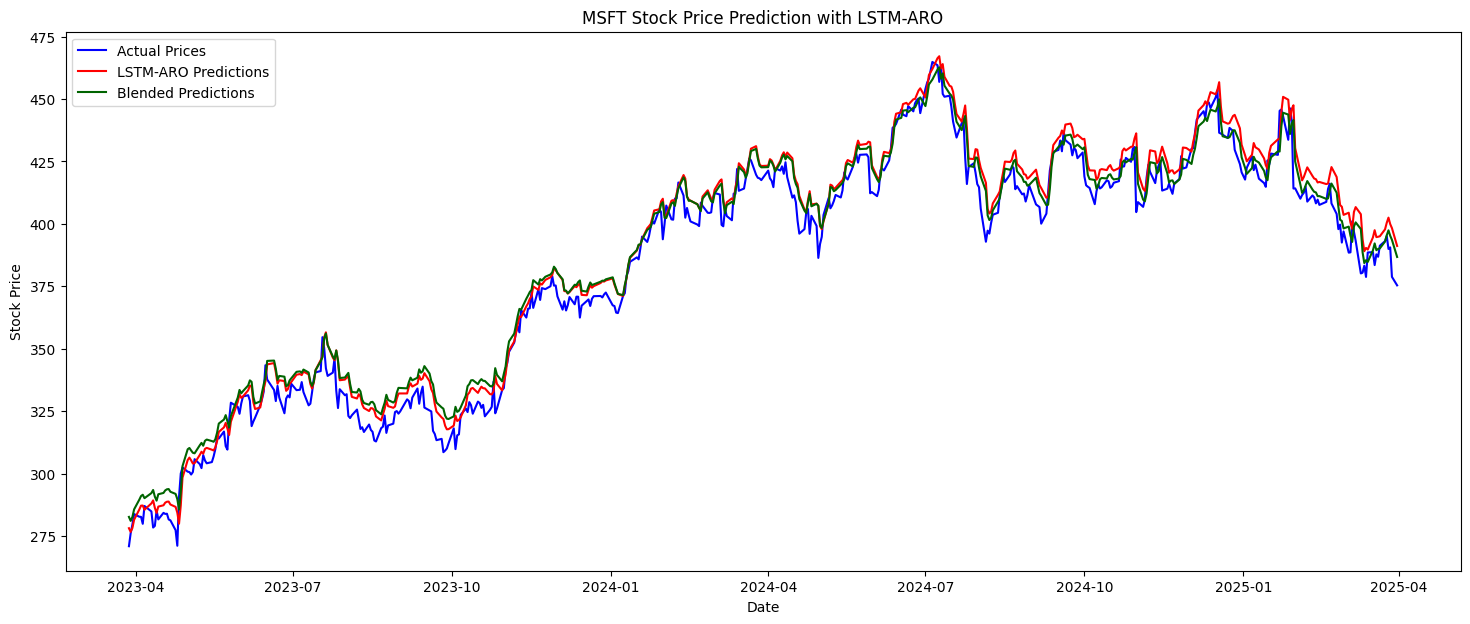

LSTM-ARO Prediction: 391.17
Blended Prediction: 386.76
MSE LSTM-ARO: 66.3148
MSE Blended: 59.6921
R² LSTM-ARO: 0.9710
R² Blended: 0.9739


In [ ]:
# @title 100 msft
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Dropout,
    Input,
    Attention,
    Concatenate,
    TimeDistributed,
)
import yfinance as yf

# Load stock data
def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Preprocess the data
def preprocess_data(data, feature="Close", window_size=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[feature].values.reshape(-1, 1))

    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i - window_size : i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

# Build the LSTM-ARO model
def build_lstm_aro_model(input_shape):
    input_layer = Input(shape=input_shape)

    # LSTM Layer
    lstm_out = LSTM(units=50, return_sequences=True)(input_layer)
    lstm_out = Dropout(0.2)(lstm_out)

    # Attention Layer
    query = Dense(50)(lstm_out)
    key = Dense(50)(lstm_out)
    value = Dense(50)(lstm_out)
    attention_out = Attention()([query, key, value])

    # Combine Attention Output and LSTM Output
    combined = Concatenate()([lstm_out, attention_out])
    combined = LSTM(units=50, return_sequences=False)(combined)
    combined = Dropout(0.2)(combined)

    # Output Layers
    dense_out = Dense(units=25)(combined)
    output_layer = Dense(units=1)(dense_out)

    # Compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

# Geometric Brownian Motion Model
def geometric_brownian_motion(S0, mu, sigma, T, steps):
    dt = T / steps
    t = np.linspace(0, T, steps)
    W = np.random.normal(0, np.sqrt(dt), size=steps).cumsum()
    S0 = S0.iloc[0]
    mu = mu.iloc[0]
    sigma = sigma.iloc[0]
    S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    return t, S

# Predict and integrate
if __name__ == "__main__":
    ticker = "MSFT"
    start_date = "2015-01-01"
    end_date = "2025-04-01"

    # Load and preprocess data
    data = load_stock_data(ticker, start_date, end_date)
    X, y, scaler = preprocess_data(data, feature="Close", window_size=60)

    # Split into training and testing sets
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Build and train the LSTM-ARO model
    model = build_lstm_aro_model(input_shape=(X_train.shape[1], 1))
    if ticker == "AAPL":
        model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
    else:
        model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

    # Predict using LSTM-ARO
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Geometric Brownian Motion Prediction
    S0 = data["Close"].iloc[-1]
    mu = data["Close"].pct_change().mean() * 252  # Annualized mean return
    sigma = data["Close"].pct_change().std() * np.sqrt(252)  # Annualized volatility
    T = 1  # Time horizon in years
    steps = len(y_test)

    t, gbm_prices = geometric_brownian_motion(S0, mu, sigma, T, steps)

    # Combine predictions
    gbm_prices_resized = gbm_prices[-len(predictions):]
    blended_predictions = 0.95 * predictions.flatten() + 0.05 * gbm_prices_resized

    # Calculate Performance Metrics
    mse_lstm_aro = mean_squared_error(y_test_actual, predictions)
    mse_gbm = mean_squared_error(y_test_actual, gbm_prices_resized)
    mse_blended = mean_squared_error(y_test_actual, blended_predictions)

    r2_lstm_aro = r2_score(y_test_actual, predictions)
    r2_gbm = max(-1, min(1, r2_score(y_test_actual, gbm_prices_resized)))
    r2_blended = r2_score(y_test_actual, blended_predictions)

    # Plot results
    plt.figure(figsize=(18, 7))
    actual_dates = data.index[-len(y_test) :]
    plt.plot(actual_dates, y_test_actual, color="blue", label="Actual Prices")
    plt.plot(actual_dates, predictions, color="red", label="LSTM-ARO Predictions")
    plt.plot(actual_dates, blended_predictions, color="darkgreen", label="Blended Predictions")
    plt.title(f"{ticker} Stock Price Prediction with LSTM-ARO")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

    print(f"LSTM-ARO Prediction: {predictions[-1][0]:.2f}")
    print(f"Blended Prediction: {blended_predictions[-1]:.2f}")
    print(f"MSE LSTM-ARO: {mse_lstm_aro:.4f}")
    print(f"MSE Blended: {mse_blended:.4f}")
    print(f"R² LSTM-ARO: {r2_lstm_aro:.4f}")
    print(f"R² Blended: {r2_blended:.4f}")


[*********************100%***********************]  1 of 1 completed

Epoch 1/100


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0297 - val_loss: 0.0050
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 9.9464e-04 - val_loss: 0.0029
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 8.2280e-04 - val_loss: 0.0015
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 8.5023e-04 - val_loss: 0.0011
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 7.8334e-04 - val_loss: 0.0044
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 9.3508e-04 - val_loss: 0.0015
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 7.9773e-04 - val_loss: 0.0085
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 8.1528e-04 - val_loss: 0.0015
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 6.6803e-04 - val_loss: 0.0030
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 6.5576e-04 - val_loss: 9.5782e-04
Epoch 12/100
63/63 ━━

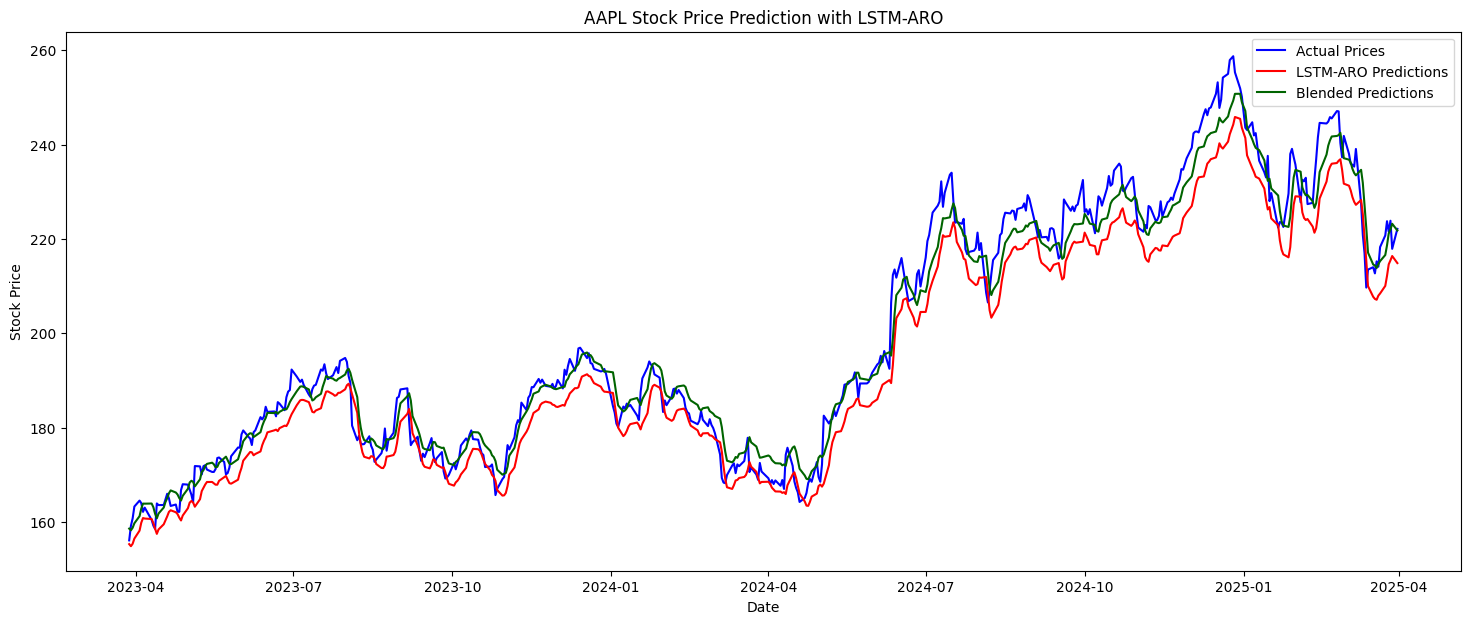

LSTM-ARO Prediction: 214.87
Blended Prediction: 221.79
MSE LSTM-ARO: 47.0382
MSE Blended: 17.4213
R² LSTM-ARO: 0.9315
R² Blended: 0.9746


In [ ]:
# @title 100 aapl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Dropout,
    Input,
    Attention,
    Concatenate,
    TimeDistributed,
)
import yfinance as yf

# Load stock data
def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Preprocess the data
def preprocess_data(data, feature="Close", window_size=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[feature].values.reshape(-1, 1))

    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i - window_size : i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

# Build the LSTM-ARO model
def build_lstm_aro_model(input_shape):
    input_layer = Input(shape=input_shape)

    # LSTM Layer
    lstm_out = LSTM(units=50, return_sequences=True)(input_layer)
    lstm_out = Dropout(0.2)(lstm_out)

    # Attention Layer
    query = Dense(50)(lstm_out)
    key = Dense(50)(lstm_out)
    value = Dense(50)(lstm_out)
    attention_out = Attention()([query, key, value])

    # Combine Attention Output and LSTM Output
    combined = Concatenate()([lstm_out, attention_out])
    combined = LSTM(units=50, return_sequences=False)(combined)
    combined = Dropout(0.2)(combined)

    # Output Layers
    dense_out = Dense(units=25)(combined)
    output_layer = Dense(units=1)(dense_out)

    # Compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

# Geometric Brownian Motion Model
def geometric_brownian_motion(S0, mu, sigma, T, steps):
    dt = T / steps
    t = np.linspace(0, T, steps)
    W = np.random.normal(0, np.sqrt(dt), size=steps).cumsum()
    S0 = S0.iloc[0]
    mu = mu.iloc[0]
    sigma = sigma.iloc[0]
    S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    return t, S

# Predict and integrate
if __name__ == "__main__":
    ticker = "AAPL"
    start_date = "2015-01-01"
    end_date = "2025-04-01"

    # Load and preprocess data
    data = load_stock_data(ticker, start_date, end_date)
    X, y, scaler = preprocess_data(data, feature="Close", window_size=60)

    # Split into training and testing sets
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Build and train the LSTM-ARO model
    model = build_lstm_aro_model(input_shape=(X_train.shape[1], 1))
    if ticker == "AAPL":
        model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
    else:
        model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

    # Predict using LSTM-ARO
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Geometric Brownian Motion Prediction
    S0 = data["Close"].iloc[-1]
    mu = data["Close"].pct_change().mean() * 252  # Annualized mean return
    sigma = data["Close"].pct_change().std() * np.sqrt(252)  # Annualized volatility
    T = 1  # Time horizon in years
    steps = len(y_test)

    t, gbm_prices = geometric_brownian_motion(S0, mu, sigma, T, steps)

    # Combine predictions
    gbm_prices_resized = gbm_prices[-len(predictions):]
    blended_predictions = 0.95 * predictions.flatten() + 0.05 * gbm_prices_resized

    # Calculate Performance Metrics
    mse_lstm_aro = mean_squared_error(y_test_actual, predictions)
    mse_gbm = mean_squared_error(y_test_actual, gbm_prices_resized)
    mse_blended = mean_squared_error(y_test_actual, blended_predictions)

    r2_lstm_aro = r2_score(y_test_actual, predictions)
    r2_gbm = max(-1, min(1, r2_score(y_test_actual, gbm_prices_resized)))
    r2_blended = r2_score(y_test_actual, blended_predictions)

    # Plot results
    plt.figure(figsize=(18, 7))
    actual_dates = data.index[-len(y_test) :]
    plt.plot(actual_dates, y_test_actual, color="blue", label="Actual Prices")
    plt.plot(actual_dates, predictions, color="red", label="LSTM-ARO Predictions")
    plt.plot(actual_dates, blended_predictions, color="darkgreen", label="Blended Predictions")
    plt.title(f"{ticker} Stock Price Prediction with LSTM-ARO")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

    print(f"LSTM-ARO Prediction: {predictions[-1][0]:.2f}")
    print(f"Blended Prediction: {blended_predictions[-1]:.2f}")
    print(f"MSE LSTM-ARO: {mse_lstm_aro:.4f}")
    print(f"MSE Blended: {mse_blended:.4f}")
    print(f"R² LSTM-ARO: {r2_lstm_aro:.4f}")
    print(f"R² Blended: {r2_blended:.4f}")

[*********************100%***********************]  1 of 1 completed

Epoch 1/100


124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0121 - val_loss: 0.0031
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 9.6927e-04 - val_loss: 9.9136e-04
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 8.0571e-04 - val_loss: 0.0010
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 8.0233e-04 - val_loss: 8.4047e-04
Epoch 9/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 8.1957e-04 - val_loss: 6.5627e-04
Epoch 10/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 7.4267e-04 - val_loss: 7.1019e-04
Epoch 11/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 7.0729e-04 - val_loss: 6

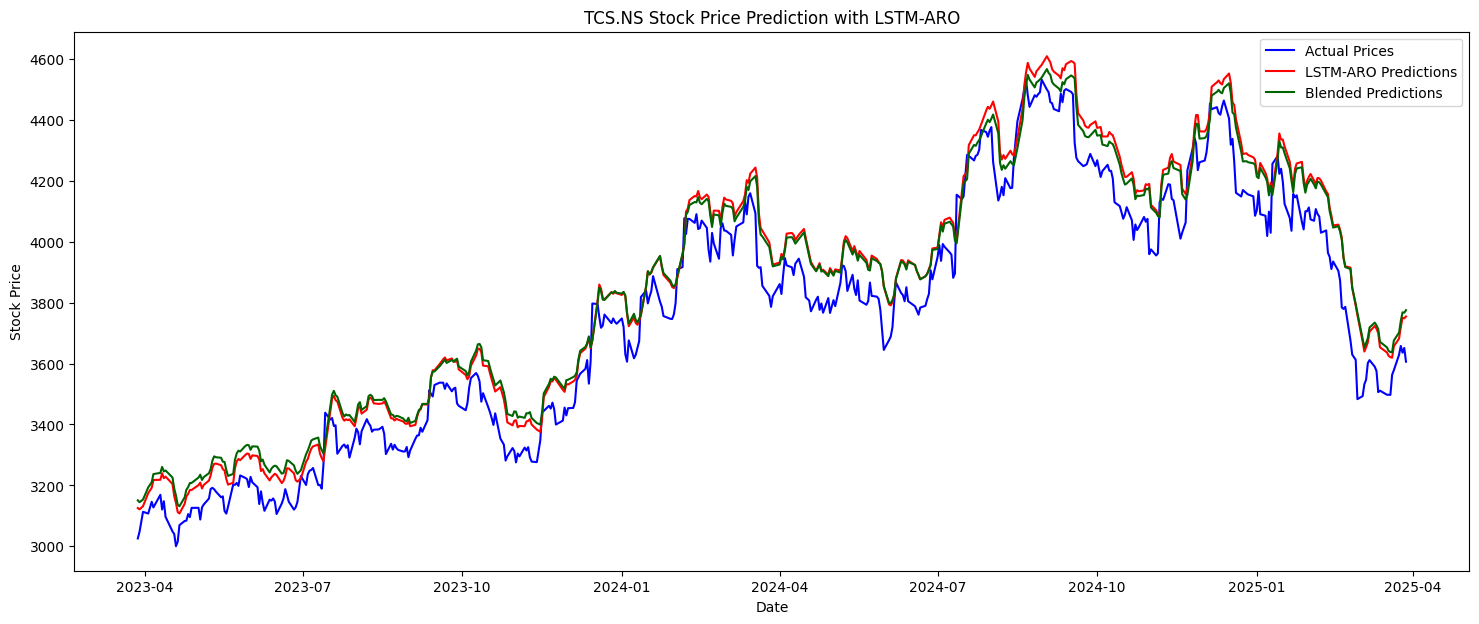

LSTM-ARO Prediction: 3754.34
Blended Prediction: 3775.13
MSE LSTM-ARO: 12709.8361
MSE Blended: 12194.5007
R² LSTM-ARO: 0.9227
R² Blended: 0.9258


In [ ]:
# @title 100 tcs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Dropout,
    Input,
    Attention,
    Concatenate,
    TimeDistributed,
)
import yfinance as yf

# Load stock data
def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Preprocess the data
def preprocess_data(data, feature="Close", window_size=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[feature].values.reshape(-1, 1))

    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i - window_size : i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

# Build the LSTM-ARO model
def build_lstm_aro_model(input_shape):
    input_layer = Input(shape=input_shape)

    # LSTM Layer
    lstm_out = LSTM(units=50, return_sequences=True)(input_layer)
    lstm_out = Dropout(0.2)(lstm_out)

    # Attention Layer
    query = Dense(50)(lstm_out)
    key = Dense(50)(lstm_out)
    value = Dense(50)(lstm_out)
    attention_out = Attention()([query, key, value])

    # Combine Attention Output and LSTM Output
    combined = Concatenate()([lstm_out, attention_out])
    combined = LSTM(units=50, return_sequences=False)(combined)
    combined = Dropout(0.2)(combined)

    # Output Layers
    dense_out = Dense(units=25)(combined)
    output_layer = Dense(units=1)(dense_out)

    # Compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

# Geometric Brownian Motion Model
def geometric_brownian_motion(S0, mu, sigma, T, steps):
    dt = T / steps
    t = np.linspace(0, T, steps)
    W = np.random.normal(0, np.sqrt(dt), size=steps).cumsum()
    S0 = S0.iloc[0]
    mu = mu.iloc[0]
    sigma = sigma.iloc[0]
    S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    return t, S

# Predict and integrate
if __name__ == "__main__":
    ticker = "TCS.NS"
    start_date = "2015-01-01"
    end_date = "2025-04-01"

    # Load and preprocess data
    data = load_stock_data(ticker, start_date, end_date)
    X, y, scaler = preprocess_data(data, feature="Close", window_size=60)

    # Split into training and testing sets
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Build and train the LSTM-ARO model
    model = build_lstm_aro_model(input_shape=(X_train.shape[1], 1))
    if ticker == "AAPL":
        model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
    else:
        model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

    # Predict using LSTM-ARO
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Geometric Brownian Motion Prediction
    S0 = data["Close"].iloc[-1]
    mu = data["Close"].pct_change().mean() * 252  # Annualized mean return
    sigma = data["Close"].pct_change().std() * np.sqrt(252)  # Annualized volatility
    T = 1  # Time horizon in years
    steps = len(y_test)

    t, gbm_prices = geometric_brownian_motion(S0, mu, sigma, T, steps)

    # Combine predictions
    gbm_prices_resized = gbm_prices[-len(predictions):]
    blended_predictions = 0.95 * predictions.flatten() + 0.05 * gbm_prices_resized

    # Calculate Performance Metrics
    mse_lstm_aro = mean_squared_error(y_test_actual, predictions)
    mse_gbm = mean_squared_error(y_test_actual, gbm_prices_resized)
    mse_blended = mean_squared_error(y_test_actual, blended_predictions)

    r2_lstm_aro = r2_score(y_test_actual, predictions)
    r2_gbm = max(-1, min(1, r2_score(y_test_actual, gbm_prices_resized)))
    r2_blended = r2_score(y_test_actual, blended_predictions)

    # Plot results
    plt.figure(figsize=(18, 7))
    actual_dates = data.index[-len(y_test) :]
    plt.plot(actual_dates, y_test_actual, color="blue", label="Actual Prices")
    plt.plot(actual_dates, predictions, color="red", label="LSTM-ARO Predictions")
    plt.plot(actual_dates, blended_predictions, color="darkgreen", label="Blended Predictions")
    plt.title(f"{ticker} Stock Price Prediction with LSTM-ARO")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

    print(f"LSTM-ARO Prediction: {predictions[-1][0]:.2f}")
    print(f"Blended Prediction: {blended_predictions[-1]:.2f}")
    print(f"MSE LSTM-ARO: {mse_lstm_aro:.4f}")
    print(f"MSE Blended: {mse_blended:.4f}")
    print(f"R² LSTM-ARO: {r2_lstm_aro:.4f}")
    print(f"R² Blended: {r2_blended:.4f}")
